# Условие

Задание
1. Реализайте архитектуру GAN на датасете FashionMNIST, где генератор будет написан на архитектуре сверточной сети
2. Реализуйте архитектуру сверточной нейронной сети, которая будет обучена на датасете FashionMNIST, для классификации ваших сгенерированных изображений
3. Прокомментировать цикл обучения (дать комментарии кода процесса обучения)

Оценка будет снижена, если
1) Архитектура генератора написана без использование сверточных слоев
2) Обучение модели написано не для GPU
3) Нет никаких комментариев в работе

Оценивание
### 8 балов за задание(1) и 2 бала за задание(2)

### Задание можно выполнить на датасете MNIST
### НО, тогда градация балов будет: 5 за задание(1) и 2 за задание(2)

# Нужные импорты, скачивание датасета и просмотр каких-то базовых вещей о нем

In [ ]:
import torchvision
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
from torch import nn

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'{device} используется')

cuda используется


In [ ]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])

In [ ]:
train_data = torchvision.datasets.FashionMNIST(root='./data',download=True,train = True,transform = transform)

In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)

In [ ]:
train_loader

In [ ]:
print(f"Датасет: {len(train_data)}, батчи: {len(train_loader)} ")

Датасет: 60000, батчи: 1875 


In [ ]:
print(f'размер картинки {train_data[0][0].shape}')

размер картинки torch.Size([1, 28, 28])


In [ ]:
fashion_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
print(len(fashion_classes))

10


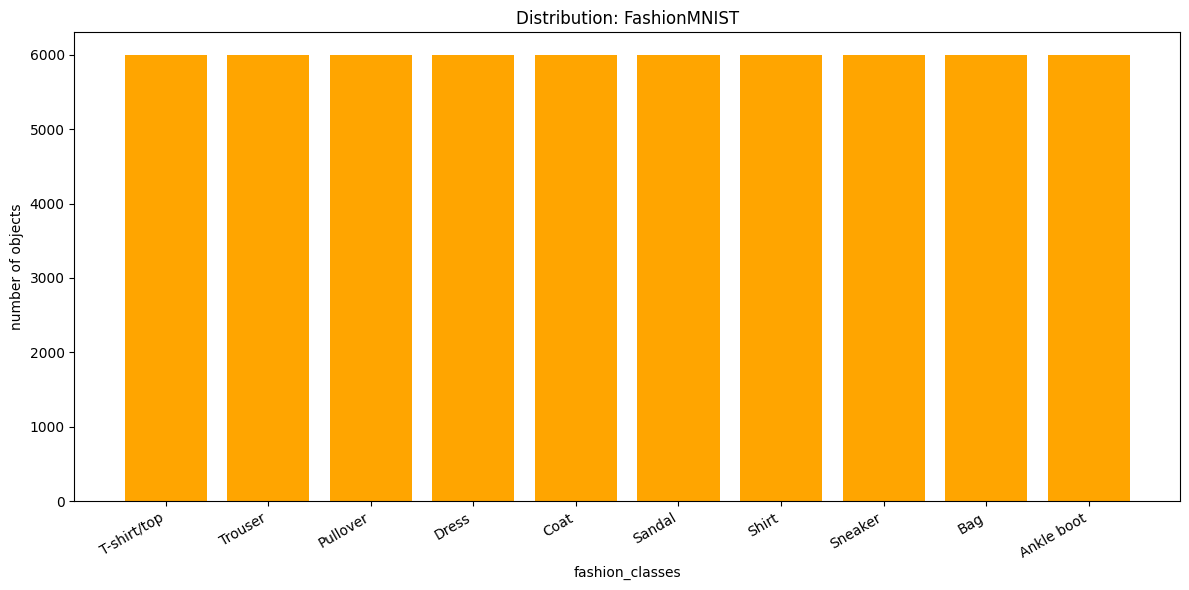

In [ ]:
labels = [label for i, label in train_data]

class_counts = Counter(labels)
sorted_class_counts = sorted(class_counts.items())


class_labels = [fashion_classes[idx] for idx, i in sorted_class_counts]
counts = [count for _, count in sorted_class_counts]


plt.figure(figsize=(12, 6))
plt.bar(class_labels, counts, color='orange')
plt.xlabel('fashion_classes')
plt.ylabel('number of objects')
plt.title('Distribution: FashionMNIST')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

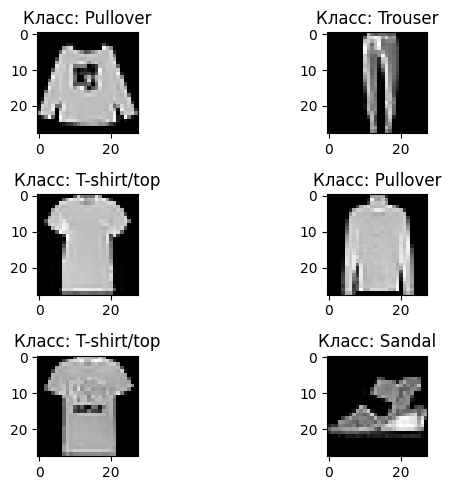

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(7, 5))

for i in range(6):
    idx = np.random.randint(0, len(train_data))
    image, label = train_data[idx]

    row = i // 2
    col = i % 2

    axes[row, col].imshow(image.reshape(28,28), cmap='grey')
    axes[row, col].set_title(f'Класс: {fashion_classes[label]}')

plt.tight_layout()
plt.show()

Что мы узнали важного о нашем датасете:
- каждая картинка 28 на 28 пикселей
- всего 10 классов
- по всем классам объекты (фото) сбалансированы абсолютно равномерно (по 60000)

# 1 задание

## Нужные классы

***Class D***:


D - линейный discriminator

как и советовали на семинаре использовала LeakyReLU вместо обычного Relu, чтобы избежать отклбчения нейррнов с отрицательынм весом

в целом класс построен по тому же принципу, что и в семинаре

4 линейных слоя, dropout по 30%

In [ ]:
class D(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28,1024), # изначально знаем что у нас картинки 28x28
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024,512),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(512,256),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(256,1),
            nn.Sigmoid() # получаем вероятность что изображение реальное или сгенерированное
        )


    def forward(self,x):
        x = x.view(x.size(0),28*28)
        output = self.model(x)
        return output

***Class G***:



G - сверточный generator

аналогично Relu --> leakyRelu

я пробовала с разным количеством слоев, но у меня получались плохие достаточно плохие результаты, поэтому я сначала увеличиваю изображение в несколько раз (через ConvTranspose2d), а затем уже через Conv2d сжимаю каналы.

Также применяется BatchNorm2d после каждого слоя, чтобы стабилизировать распределение активаций и ускорить обучение.

Финальный слой — Conv2d с Tanh, чтобы привести значения пикселей к диапазону [-1, 1]

In [ ]:
noise = 100

In [ ]:
class G(nn.Module):
    def __init__(self, noise=100):
        super().__init__()

        self.fc = nn.Linear(noise, 256*7*7) # из шума создаем тензор нам нужного размера

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(256),

            # 1 слой (увеличение и стабилизация): 7x7 -> 14x14
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),

            # 2 слой (увеличение и нормализация): 14x14 -> 28x28
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),

            # 3 сверт слой с умененьшем количества каналов и нормализацией: 64 -> 32
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),

            # 4 cверт слой с сокращением количества каналов до чб изображенияя
            nn.Conv2d(32, 1, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, batch_noise): # прямой проход
        out = self.fc(batch_noise)
        out = out.view(batch_noise.size(0), 256, 7, 7)  # шум в тензор
        image_gen = self.conv_blocks(out)
        return image_gen


## Обучение и визуализция

In [ ]:
generator = G(noise)
discriminator = D()

num_epoch = 25 # при 20 эпохах и меньше не получается набрать лосс дискриминатора больше 0.5, а при таком колчиестве эпох он почти достигает к 0.6
lr = 0.0005
loss_function = nn.BCELoss() # используем BCELoss так как у нас только 2 класса: реальное изображение vs сгенерированное

optimizer_d = torch.optim.Adam(discriminator.parameters(),lr=lr) # стандартный оптимайзер (будет использоваться везде в работе)
optimizer_g = torch.optim.Adam(generator.parameters(),lr=lr)

In [ ]:
%%time

losses_d = [] # список значений лосса, чтобы потом визуализировать (ловит)
losses_g = [] # псписок значений лосса, чтобы потом визуализировать (генерит)

for epoch in range(num_epoch):
    epoch_loss_d = 0.0 # подсчет лосса, чтобы потом визуализировать (ловит)
    epoch_loss_g = 0.0 # подсчет лосса, чтобы потом визуализировать (генерит)


    for n, (real_samples, i) in enumerate(train_loader):
        generator.to(device) # на gpu
        discriminator.to(device) # на gpu

        batch_size = real_samples.size(0)
        real_samples = real_samples.to(device) # реальные изображения FashionMNIST

        real_samples = real_samples.to(device)
        current_batch_size = real_samples.size(0)

        # 1 - реальные, 0 - сгенерированные
        real_labels = torch.ones(batch_size,1, device=device)
        fake_labels = torch.zeros(batch_size,1, device=device)

        # -------
        for_fake = torch.randn(batch_size, noise, device=device) # noise определен на несколько ячеек выше
        fake_samples = generator(for_fake)

        # объединяем сгенерированные картинки и лейблы с настоящими в одну выборку, чтобы уже на них всё обучать
        all_samples = torch.cat([real_samples, fake_samples], dim=0)
        all_labels = torch.cat([real_labels, fake_labels], dim=0)

        # D training, c обнулением весов, обрытнм проходом, полсчетом лосса и применением оптимайзера
        discriminator.zero_grad()
        output_d = discriminator(all_samples)
        loss_d = loss_function(output_d, all_labels)
        loss_d.backward()
        optimizer_d.step()


        # -------
        fake_for_g = torch.randn(batch_size, noise, device=device)
        generator.zero_grad()

         # G training
        fake_samples = generator(fake_for_g)
        output_d_g = discriminator(fake_samples)
        loss_g = loss_function(output_d_g, real_labels) # наша цель real_labels
        loss_g.backward()
        optimizer_g.step()


        epoch_loss_d += loss_d.item() # на каждом этапе накапливаем лосс
        epoch_loss_g += loss_g.item() # на каждом этапе накапливаем лосс

        if n == len(train_loader) - 1:
            avg_loss_d = epoch_loss_d / len(train_loader)
            avg_loss_g = epoch_loss_g / len(train_loader)
            losses_d.append(avg_loss_d)
            losses_g.append(avg_loss_g)
            print(f'{epoch} LOSS D: {avg_loss_d}')
            print(f'{epoch} LOSS G: {avg_loss_g}')


0 LOSS D: 0.3711627294500669
0 LOSS G: 2.0803594855944314
1 LOSS D: 0.47359251198768615
1 LOSS G: 1.4257183879534403
2 LOSS D: 0.5330864940961202
2 LOSS G: 1.2003510595957438
3 LOSS D: 0.555795236380895
3 LOSS G: 1.1213993790626526
4 LOSS D: 0.5689268481095632
4 LOSS G: 1.0850406432787578
5 LOSS D: 0.5784418009757996
5 LOSS G: 1.0572591423988342
6 LOSS D: 0.575615554857254
6 LOSS G: 1.0739365904808045
7 LOSS D: 0.5778075968901316
7 LOSS G: 1.053607894897461
8 LOSS D: 0.5762940118630727
8 LOSS G: 1.0700348622957865
9 LOSS D: 0.5807485034624735
9 LOSS G: 1.0531864631970724
10 LOSS D: 0.5839233540217081
10 LOSS G: 1.0410262077649435
11 LOSS D: 0.5912203530311585
11 LOSS G: 1.0160652565638224
12 LOSS D: 0.588443474038442
12 LOSS G: 1.027665308602651
13 LOSS D: 0.5875797639369965
13 LOSS G: 1.0268814830462138
14 LOSS D: 0.5920942164421081
14 LOSS G: 1.0099853796641032
15 LOSS D: 0.5913045450687409
15 LOSS G: 1.0104602248827617
16 LOSS D: 0.5947471869150798
16 LOSS G: 0.9991365340550741
17 L

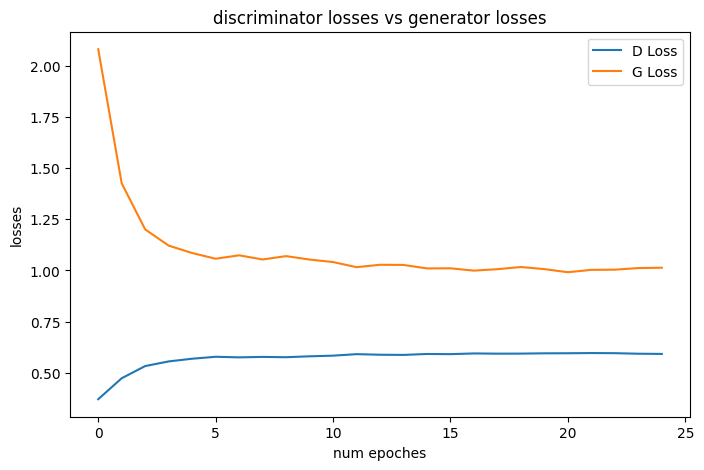

In [ ]:
# визуализация обучения генератора (G) и дискриминатора (D)
plt.figure(figsize=(8,5))
plt.plot(losses_d, label="D Loss")
plt.plot(losses_g, label="G Loss")
plt.xlabel("num epoches")
plt.ylabel("losses")
plt.title("discriminator losses vs generator losses")
plt.legend()
plt.show()

В целом, видим, что процеес обучения прошел успешно: Дискриминатор стал чуть хуже отличать сгенерированные картирнки от настоящих, а генератор стал чуть лучше создавать свои обманки!

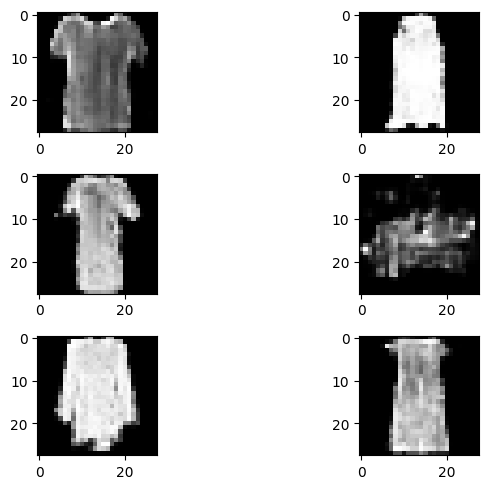

In [ ]:
def plt_generated_images(generator, device, num_images=6):
    """просто смотрим на фейковые изображения"""
    generator.eval()

    noise = torch.randn(num_images, 100).to(device)
    with torch.no_grad():
        fake_images = generator(noise).cpu()

    fake_images = fake_images.squeeze(1)

    plt.figure(figsize=(8, 5))
    for i in range(num_images):
        plt.subplot(3, 2, i + 1)
        plt.imshow(fake_images[i], cmap='gray')

    plt.tight_layout()
    plt.show()

    generator.train()



plt_generated_images(generator, device)

# 2 задание

Сразу скажу, что я немного не поняла в чем заключалось само задание, поэтому, вот, небольшая сводка того, что я сделала:
1) сам класс CNNClas
2) обучила на оригинальных (реальных) данных из датасета
3) после обучения прогнала ее на сгенерированных картинках обученным генератором из предыдущего пункта


Но я совсем не поняла, как мне измерить эти результаты( Ведь, картинки ненастоящие, а, значит, у них нет настощих лейблов и я не могу никак посчитать accuracy или какие-либо другие метрики. Можно посмотреть визуально на картинки и классы, предсказанные сверткой.

## Класс свертки и обучение

Класс свертки:


опять вместо функции активации Relu применяем LeakyRelu

на ервым двух слоях применяем MaxPool2d для того, чтобы уменьшить изображения в 2 раза (с 28x28 на 14x14, с 14x14 до 14x14)

нашла метод AdaptiveAvgPool2d, который работает также, как и обычный averege pooling, только для него не надо указывать

в целом архитектура реализована не сложная, но, как я помню по дз по обычному MNIST (по-моему, обсуждали, что это просходит, потому что это уже давно решенные задачки), там тоже архитектура была достаточная несложная, а резульаты по accuracy получались > 95%


In [ ]:
class CNNClas(nn.Module):
    def __init__(self):
        super().__init__()
        """
        conv_layers - 3 сверточных слоя для извдечения признаков
        cls - сверточный классификатор """
        self.conv_layers = nn.Sequential(
            # 1 cлой
            nn.Conv2d(1, 32, kernel_size=3, padding=1), # меняем ч/б 1 --> 32
            nn.LeakyReLU(),
            nn.MaxPool2d(2),   # cжатие, как я описала в ячейке выше

            # 2 cлой
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 32 канала --> 64
            nn.LeakyReLU(),
            nn.MaxPool2d(2),

            # 3 слой
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 64 --> 128
            nn.LeakyReLU(),
        )

        # 10 класов (знаем по датасету), 128 -- из выхода 3 слоя conv_layers
        self.cls = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=10, kernel_size=1),
            nn.AdaptiveAvgPool2d(output_size=(1, 1)))

    def forward(self, x): # в целом такая же структура, как использовалась и в семинаре, и в дискриминаторе, и в генераторе
        x = self.conv_layers(x)
        x = self.cls(x)
        x = x.view(x.size(0), -1)
        return x

In [ ]:
epochs_cnn = 30 # хватает для хороших значений accuracy

In [ ]:
cnn = CNNClas().to(device)
optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=0.0001)
criterion_cnn = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(epochs_cnn):
    total_loss = 0 # три накапливателя, для того, чтобы потом можно было посчитать accyracy и loss
    total_samples = 0
    correct_predictions = 0

    for images_real, labels_real in train_loader: # train по реальных изображениям
        images_real = images_real.to(device)
        labels_real = labels_real.to(device)

        optimizer_cnn.zero_grad()
        outputs = cnn(images_real)

        loss = criterion_cnn(outputs, labels_real)
        loss.backward()
        optimizer_cnn.step()

        total_loss += loss.item() # считает лосс

        predicted_classes = outputs.argmax(dim=1) # наиболее вероятныъ класс

        ok = (predicted_classes == labels_real) # правильно предсказанный класс изображения
        correct_predictions += ok.sum().item()

        total_samples += labels_real.shape[0]

    avg_loss = total_loss / len(train_loader) # средний лосс на эпоху обучения
    accuracy = correct_predictions / total_samples # accuracy на эпоху обучения

    print(f"Epoch {epoch+1}: Losses: {avg_loss} and Accuracy : {accuracy}")


Epoch 1: Losses: 0.3974197147766749 and Accuracy : 0.8587833333333333
Epoch 2: Losses: 0.3912966671665509 and Accuracy : 0.8601666666666666
Epoch 3: Losses: 0.38552898159424465 and Accuracy : 0.86315
Epoch 4: Losses: 0.378748110584418 and Accuracy : 0.8653166666666666
Epoch 5: Losses: 0.3740368736068408 and Accuracy : 0.8674666666666667
Epoch 6: Losses: 0.36838468456665674 and Accuracy : 0.8684166666666666
Epoch 7: Losses: 0.3643151669581731 and Accuracy : 0.87025
Epoch 8: Losses: 0.3590881985704104 and Accuracy : 0.8712
Epoch 9: Losses: 0.35459381733934087 and Accuracy : 0.8729166666666667
Epoch 10: Losses: 0.3496332807898521 and Accuracy : 0.87525
Epoch 11: Losses: 0.34633316815098125 and Accuracy : 0.8774833333333333
Epoch 12: Losses: 0.34239418110052744 and Accuracy : 0.8770166666666667
Epoch 13: Losses: 0.3371282989164193 and Accuracy : 0.8797666666666667
Epoch 14: Losses: 0.3338349388082822 and Accuracy : 0.8814833333333333
Epoch 15: Losses: 0.3306057718157768 and Accuracy : 0.88

В целом, даже при таком небольшом количестве эпох получаются достаточные неплохие результаты (на трейне! я не проверяла на тестовой выборке (которая есть у датасета), потому что не стояло такой задачи и эта задача не была бы как-то связана с обученным генератором)

## совсем сомнительная штука:

Единственная польза от следующего кода -- это то, что мы можем оценить насколько совпадают присвоенные классы классификатором с классами, присвоенными рандомно (после того, как сгенерировали фотографии).
То есть в такой задаче нам хотелось бы получить небольшие значения accuracy; это будет говорить нам о том, что классификатор присваивает метки классам не рандомно.

In [ ]:
def cnn_on_generated(generator, cnn, device, num_images=10000):
    """
    Оценка качества CNN на сгенерированных изображениях:
    считаем accuracy между искусственно сгенерированными метками классов
    и реальными, которые предсказал сверточный классификатор
    """
    generator.eval()
    cnn.eval()


    noise = 100
    noise = torch.randn(num_images, noise, device=device)

    with torch.no_grad():
        gen_images = generator(noise)

    # задаём случайные классы (поскольку картинки gan сделал)
    gen_labels = torch.randint(0, 10, (num_images,), device=device)

    # прямой проход CNN
    with torch.no_grad():
        outputs = cnn(gen_images)

    # Вычисляем accuracy
    predicted_classes = outputs.argmax(dim=1)
    matches = (predicted_classes == gen_labels)
    correct_predictions = matches.sum().item()
    accuracy = correct_predictions / num_images

    return accuracy



In [ ]:
def show_generated_images_with_predictions(generator, cnn, device, num_images=16):
    """
    Показывает сгенерированные изображения:
    - сверху: сгенерированная (случайная) метка
    - снизу: предсказанная CNN метка
    """

    generator.eval()
    cnn.eval()

    # получаем искусственные фотографии, генератор был обучен в предыдущем пункте
    noise = torch.randn(num_images, 100, device=device)
    with torch.no_grad():
        gen_images = generator(noise).cpu()

    # еенерируем случайные метки
    gen_labels = torch.randint(0, 10, (num_images,))

    # CNN предсказания
    with torch.no_grad():
        outputs = cnn(gen_images.to(device))
        cnn_labels = outputs.argmax(dim=1).cpu()

    # Названия классов FashionMNIST
    fashion_classes = [
        'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
    ]

    rows = 20
    cols = 10
    fig, axes = plt.subplots(rows, cols, figsize=(20, 16))
    axes = axes.ravel()

    for i in range(num_images):
        axes[i].imshow(gen_images[i].squeeze(), cmap='gray')

        axes[i].set_title(
            f"Pred: {fashion_classes[cnn_labels[i]]}",
            fontsize=7
        )

        axes[i].axis('off') # иначе вообще ничего не видно

    plt.tight_layout()
    plt.show()



Generated Images - CNN Accuracy: 10.15%


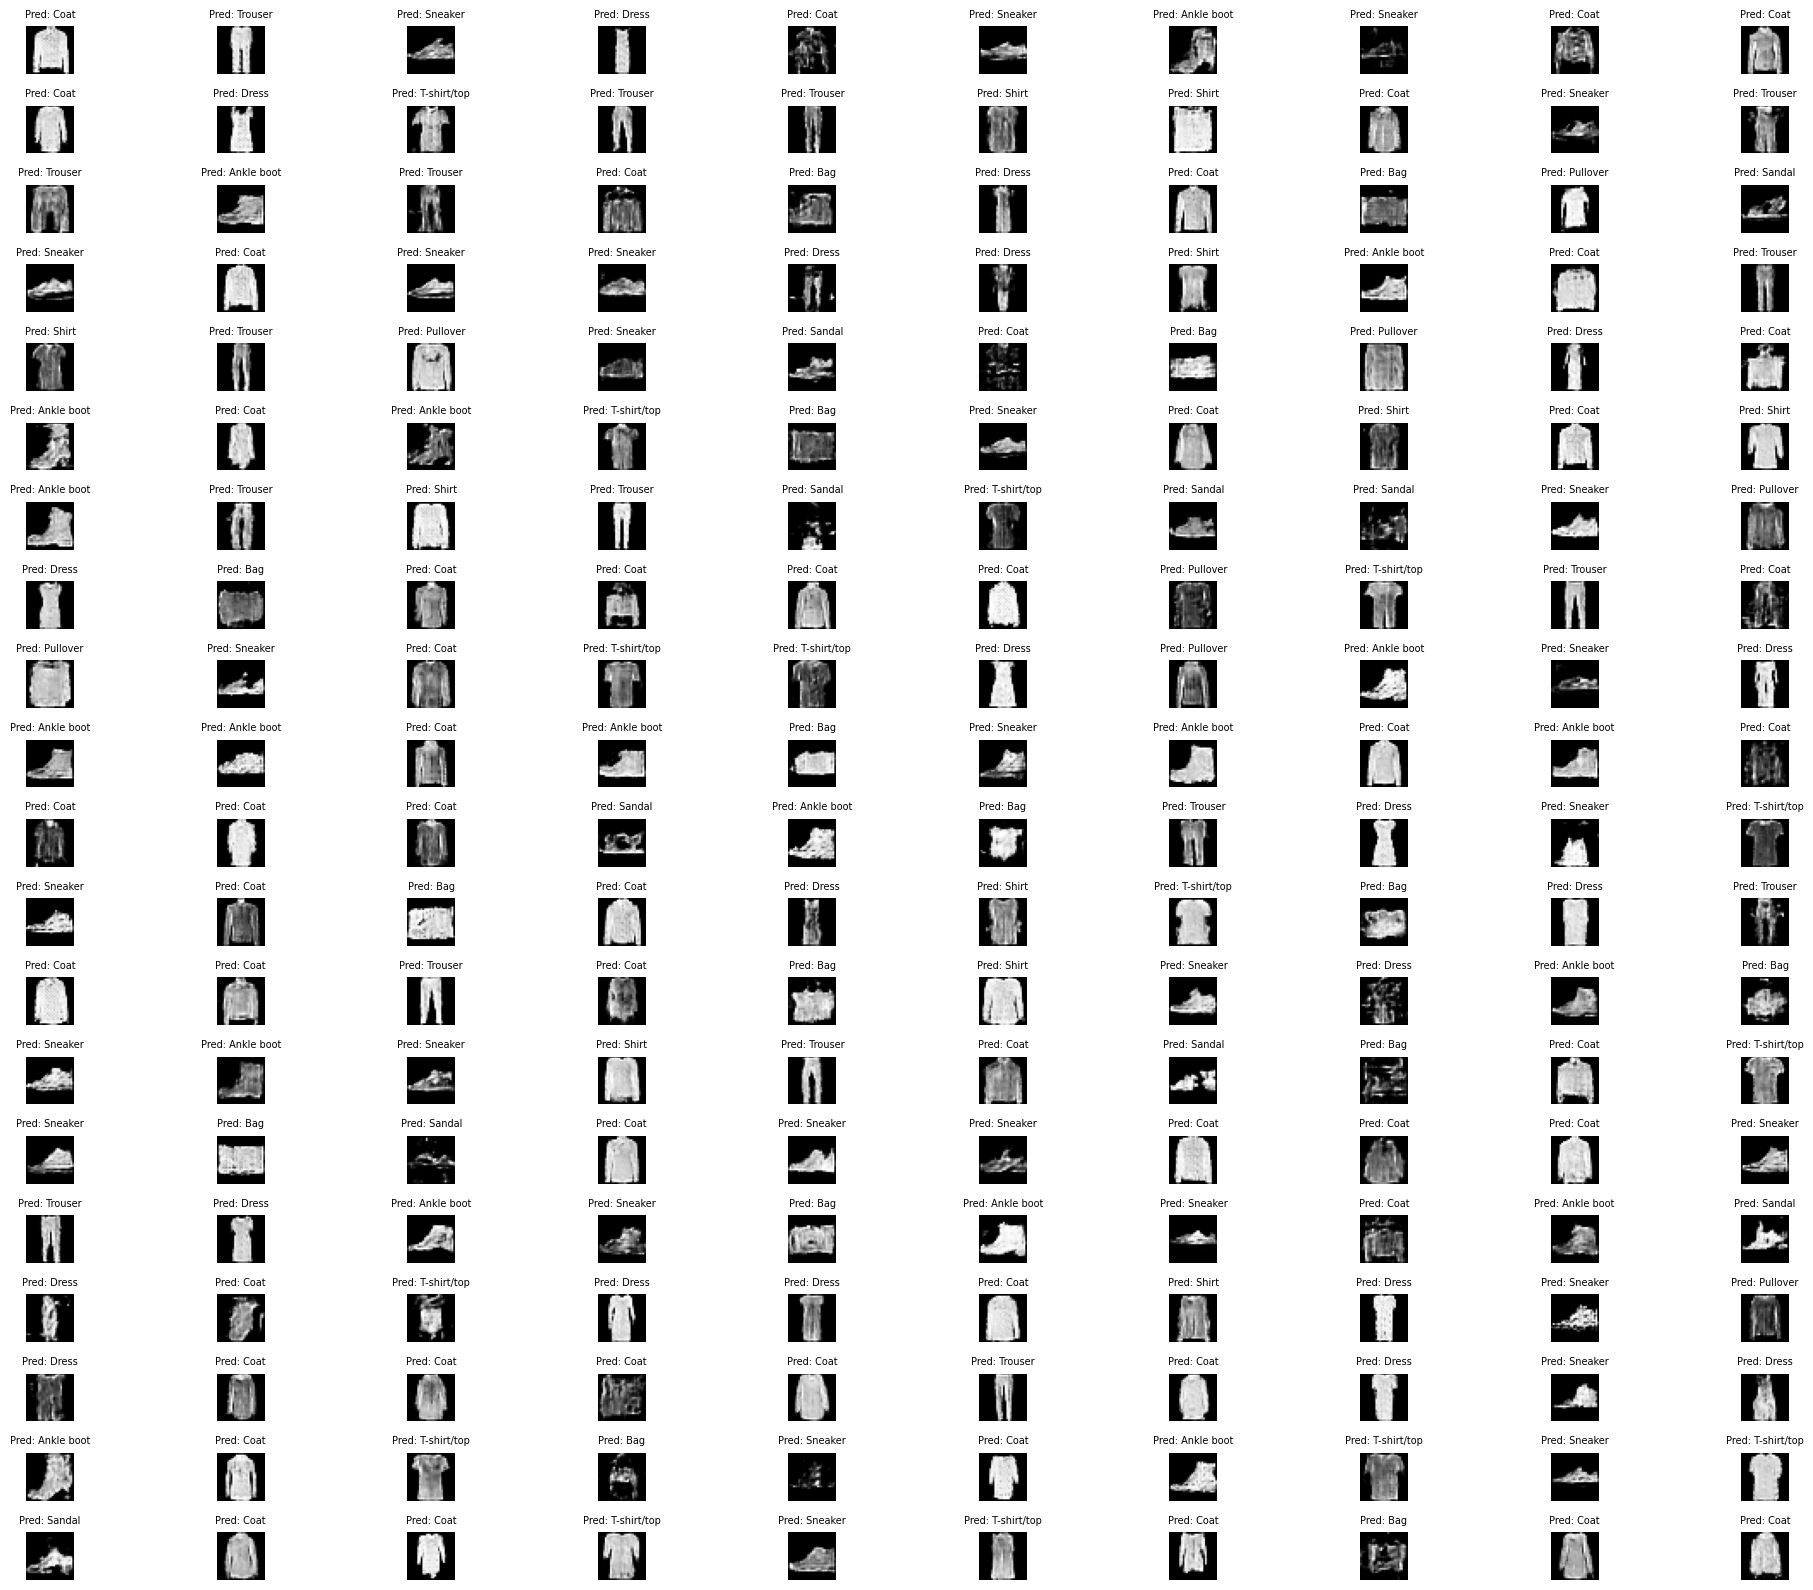

In [ ]:
# Подсчёт метрик
acc = cnn_on_generated(generator, cnn, device, num_images=10000)
print(f"Generated Images - CNN Accuracy: {acc*100:.2f}%")

# Визуализация
show_generated_images_with_predictions(generator, cnn, device, num_images=200)


Вывод: как и ожидалось, accuracy очень низкая, всего 10%
Чисто визуально, кажется, что и сгенерированные картинки -- качественные, и сами предсказания нормальные.
